In [1]:
import os
import pandas as pd


In [2]:
image_path = "/kaggle/input/flickr30k/flickr30k_images"
# /kaggle/input/flickr30k/flickr30k_images
caption_path = '/kaggle/input/flickr30k/captions.txt'
print(len(os.listdir(image_path)))

31783


In [3]:
data = pd.read_csv(caption_path)
data.head()

image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             comment  
0  Two young guys with shaggy hair look at their ...  
1  Two young  White males are outside near many b...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

In [4]:
import numpy as np

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications.xception import Xception,preprocess_input #to get pre-trained model Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2024-07-03 16:38:20.302659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 16:38:20.302781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 16:38:20.435268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
xmodel = Xception(weights='imagenet', include_top=False,pooling='avg')
xmodel.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add_24[0][0]    

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [6]:
# img_size = 299
# features = {}
# for image in tqdm(data['image_name'].unique().tolist()):
#     img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = np.expand_dims(img,axis=0)
#     img = img/127.5
#     img = img - 1.0
#     feature = model.predict(img, verbose=0)
#     features[image] = feature

In [8]:
import pickle


# with open('features.pkl', 'wb') as f:
#     pickle.dump(features, f)

In [9]:
with open('/kaggle/input/features/features.pkl', 'rb') as f:
    features = pickle.load(f)


In [7]:
print(len(features))

31783


In [15]:
def text_preprocessing(data):
    data['comment'] = data['comment'].apply(lambda x: x.lower())
    data['comment'] = data['comment'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))
    data['comment'] = data['comment'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['comment'] = "startseq "+data['comment']+" endseq"
    return data

In [16]:
data  = text_preprocessing(data)
captions  = data['comment'].tolist()
captions[:10]



['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)
print(max_length)


74


In [18]:
print(vocab_size)

18319


In [14]:
data.head()

image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             comment  
0  startseq two young guys with shaggy hair look ...  
1  startseq two young white males are outside nea...  
2  startseq two men in green shirts are standing ...  
3  startseq man in blue shirt standing in garden ...  
4  startseq two friends enjoy time spent together...

In [15]:
data.drop(columns=['comment_number'],axis =1,inplace=True)
data.head()

image_name                                            comment
0  1000092795.jpg  startseq two young guys with shaggy hair look ...
1  1000092795.jpg  startseq two young white males are outside nea...
2  1000092795.jpg  startseq two men in green shirts are standing ...
3  1000092795.jpg  startseq man in blue shirt standing in garden ...
4  1000092795.jpg  startseq two friends enjoy time spent together...

In [16]:
from sklearn.model_selection import train_test_split

train_images, val_images = train_test_split(data['image_name'].unique().tolist(), test_size=0.15, random_state=42)


train = data[data['image_name'].isin(train_images)].reset_index(drop=True)
val = data[data['image_name'].isin(val_images)].reset_index(drop=True)


print(f"Total images: {len(data['image_name'].unique())}")
print(f"Training images: {len(train_images)}, Training samples: {len(train)}")
print(f"Validation images: {len(val_images)}, Validation samples: {len(val)}")

Total images: 31783
Training images: 27015, Training samples: 135075
Validation images: 4768, Validation samples: 23840


In [17]:
tokenizer.texts_to_sequences([captions[1]])


[[1, 12, 21, 20, 708, 13, 54, 79, 194, 1421, 2]]

In [17]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [19]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

In [20]:

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(512, activation='relu')(fe1)
    fe2 = BatchNormalization()(fe2)
    fe2 = Dropout(0.2)(fe2)
    fe3 = Dense(256, activation='relu')(fe2)
    img_features_reshaped = Reshape((1, 256), input_shape=(256,))(fe3)

    
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=False)(inputs2)
    merge = concatenate([img_features_reshaped,se1],axis=1)
    se2 = Dropout(0.2)(merge)
    se3 = LSTM(256, return_sequences=True)(se2)
    se3 = Dropout(0.2)(se3)
    se4 = LSTM(256)(se3)
    
    decoder1 = add([fe3, se4])
    decoder2 = Dense(256, activation='relu')(decoder1)
    decoder2 = BatchNormalization()(decoder2)
    decoder2 = Dropout(0.2)(decoder2)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model


model = define_model(vocab_size, max_length)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 74)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 74, 256)   │  4,689,664 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 75, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 75, 256)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 75, 256)   │    525,312 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 75, 256)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense_1[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 18319)     │  4,707,983 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,697,551 (44.62 MB)

 Trainable params: 11,696,015 (44.62 MB)

 Non-trainable params: 1,536 (6.00 KB)

None


In [18]:
train_generator = CustomDataGenerator(df=train,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=val,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [22]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [ ]:
history =model.fit(
        train_generator,
        epochs=3,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])


Epoch 1/3
1557/2110 ━━━━━━━━━━━━━━━━━━━━ 8:56 969ms/step - loss: 5.7736

In [10]:
from tensorflow.keras.models import load_model

# Path to the uploaded model file or directory
model_path = '/kaggle/input/model-caption/model.keras'
# If you saved the model in a directory
# model_path = '/kaggle/input/your-uploaded-model-directory/model_directory'

# Load the model
model = load_model(model_path)

In [12]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

def predict_caption(model,img,tokenizer,max_length,features):
    feature = features[img]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 
    



In [22]:
samples = val.sample(15)
samples.reset_index(drop=True,inplace=True)

In [27]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image_name']),target_size=(299,299))
    img = img_to_array(img)
    img = img/127.5
    img = img-1
    
    caption = predict_caption(model, record['image_name'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption
    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

In [33]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [34]:
samples

image_name                                            comment  \
0   3224560800.jpg  startseq man dances with fire baton at night e...   
1   7863653456.jpg  startseq man that has removed his shoes to kne...   
2    185571867.jpg  startseq three people walk past construction z...   
3     96692346.jpg  startseq couple kissing each other standing on...   
4    274616931.jpg  startseq man is looking at some food on stick ...   
5   4853383129.jpg  startseq two young blond women wearing summer ...   
6   2345980168.jpg  startseq group of ten female synchronized swim...   
7   1159574340.jpg  startseq the man takes leap into the water wit...   
8   4878432074.jpg  startseq man of perhaps indian descent is stan...   
9   4589050600.jpg  startseq dark-haired woman is texting while wa...   
10  8190802361.jpg  startseq young man is doing skateboarding tric...   
11  4508482982.jpg  startseq woman emptying produce off cart outsi...   
12   327142149.jpg  startseq dirt floor gets swept by one white an...   
13   138235288.jpg  startseq blond woman with glasses shops at an ...   
14   412263903.jpg  startseq two boys one wearing red chiefs sweat...   

                                              caption  
0   startseq man in black shirt is standing in fro...  
1   startseq man in white shirt and jeans is sitti...  
2   startseq man in blue shirt and blue jeans is s...  
3   startseq man in black shirt and jeans is walki...  
4   startseq man in white shirt and white apron is...  
5   startseq group of people are standing on pier ...  
6           startseq two boys swimming in pool endseq  
7   startseq man in shorts and shorts is running t...  
8   startseq man in blue shirt and blue shorts is ...  
9   startseq woman in black jacket and black pants...  
10  startseq man in black shirt and jeans is skate...  
11  startseq man in blue shirt and blue jeans is w...  
12  startseq man in blue shirt sweeps the sidewalk...  
13  startseq man in black shirt and jeans is sitti...  
14  startseq man in blue shirt and black shorts is...

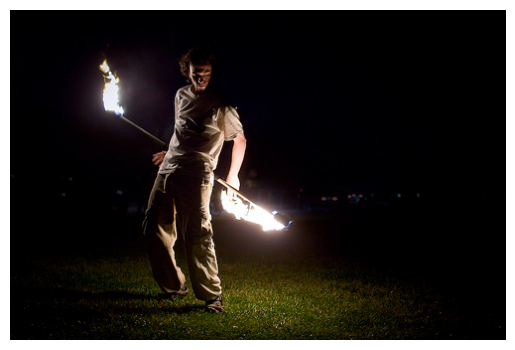

Real Caption: startseq man dances with fire baton at night endseq
Generated Caption: startseq man in black shirt is standing in front of fire endseq

--------------------------------------------------



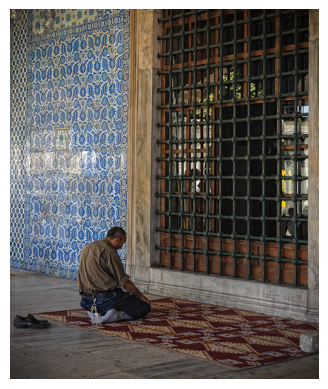

Real Caption: startseq man that has removed his shoes to kneel on mat endseq
Generated Caption: startseq man in white shirt and jeans is sitting on the sidewalk endseq

--------------------------------------------------



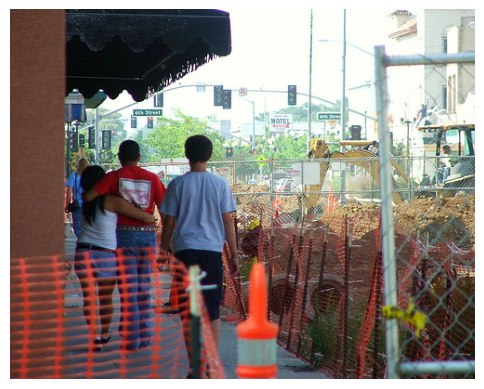

Real Caption: startseq three people walk past construction zone fenced off with orange plastic fencing endseq
Generated Caption: startseq man in blue shirt and blue jeans is standing in front of an outdoor shop endseq

--------------------------------------------------



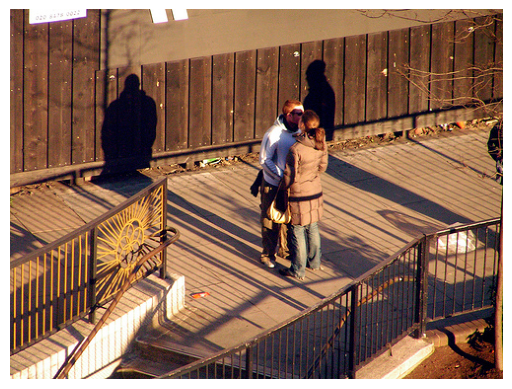

Real Caption: startseq couple kissing each other standing on what looks like peer or boardwalk of some kind endseq
Generated Caption: startseq man in black shirt and jeans is walking down the street endseq

--------------------------------------------------



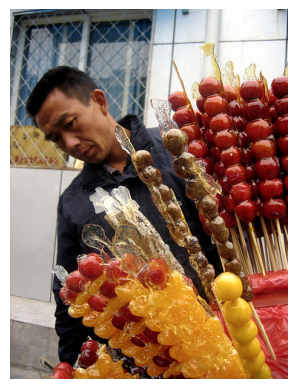

Real Caption: startseq man is looking at some food on stick to buy for himself or someone else endseq
Generated Caption: startseq man in white shirt and white apron is selling food endseq

--------------------------------------------------



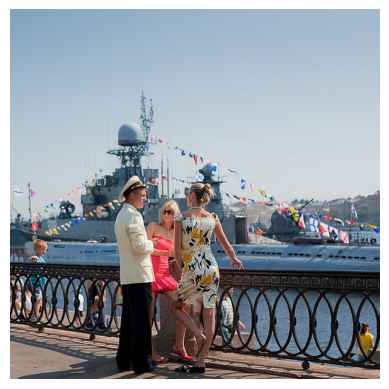

Real Caption: startseq two young blond women wearing summer dresses talk to young blond man wearing dress navy uniform in front of battleship endseq
Generated Caption: startseq group of people are standing on pier endseq

--------------------------------------------------



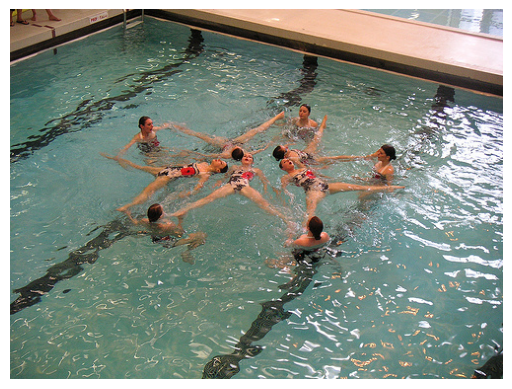

Real Caption: startseq group of ten female synchronized swimmers in formation in the pool endseq
Generated Caption: startseq two boys swimming in pool endseq

--------------------------------------------------



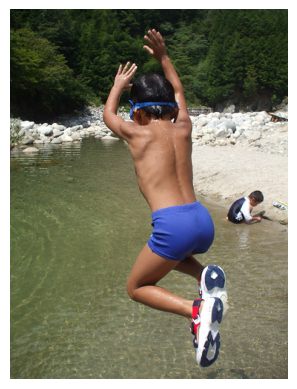

Real Caption: startseq the man takes leap into the water with his shoes on endseq
Generated Caption: startseq man in shorts and shorts is running through the water endseq

--------------------------------------------------



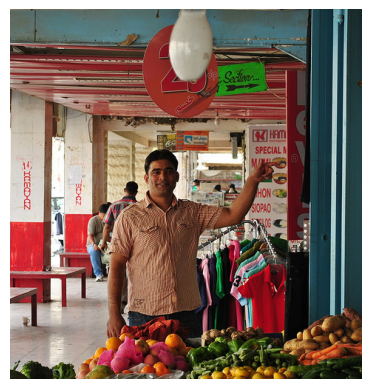

Real Caption: startseq man of perhaps indian descent is standing in an outdoor market in front of variety of produce endseq
Generated Caption: startseq man in blue shirt and blue shorts is standing in front of fruit stand endseq

--------------------------------------------------



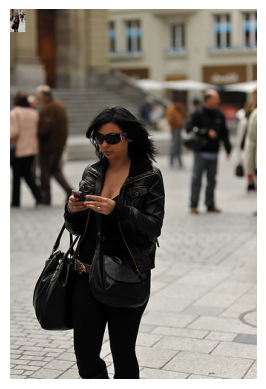

Real Caption: startseq dark-haired woman is texting while walking endseq
Generated Caption: startseq woman in black jacket and black pants is walking down the street endseq

--------------------------------------------------



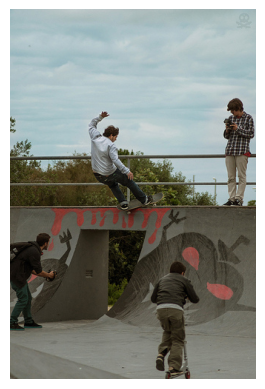

Real Caption: startseq young man is doing skateboarding trick while two guys take pictures and another is riding scooter endseq
Generated Caption: startseq man in black shirt and jeans is skateboarding on skateboard endseq

--------------------------------------------------



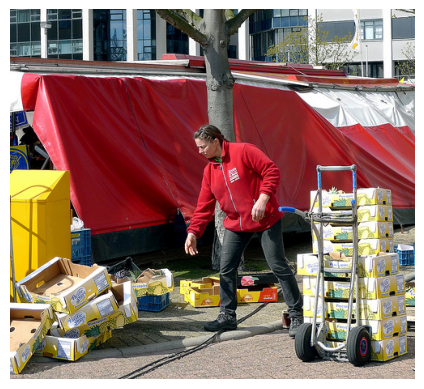

Real Caption: startseq woman emptying produce off cart outside at stand endseq
Generated Caption: startseq man in blue shirt and blue jeans is working on the street endseq

--------------------------------------------------



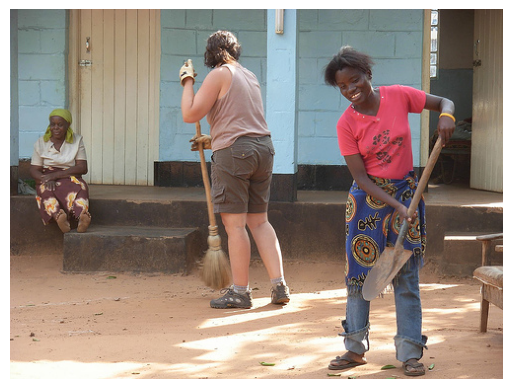

Real Caption: startseq dirt floor gets swept by one white and one black woman endseq
Generated Caption: startseq man in blue shirt sweeps the sidewalk endseq

--------------------------------------------------



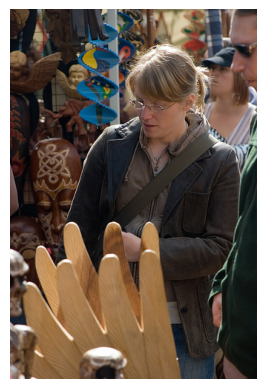

Real Caption: startseq blond woman with glasses shops at an outdoor market endseq
Generated Caption: startseq man in black shirt and jeans is sitting on the floor with his arms on his head endseq

--------------------------------------------------



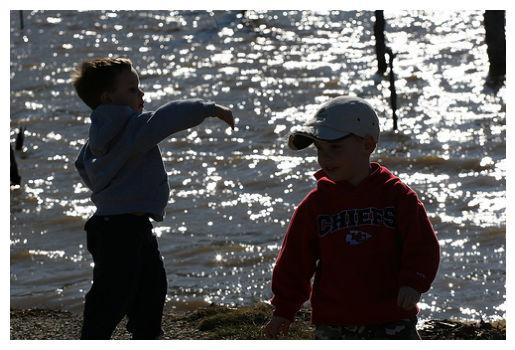

Real Caption: startseq two boys one wearing red chiefs sweatshirt plays near shore endseq
Generated Caption: startseq man in blue shirt and black shorts is standing on the beach endseq

--------------------------------------------------



In [36]:
for index, record in samples.iterrows():
    
    img = Image.open(os.path.join(image_path, record['image_name']))
    
    plt.imshow(img)
    plt.axis('off')  
    plt.show()
    
    print(f"Real Caption: {record['comment']}")
    print(f"Generated Caption: {record['caption']}")
    print("\n" + "-"*50 + "\n")

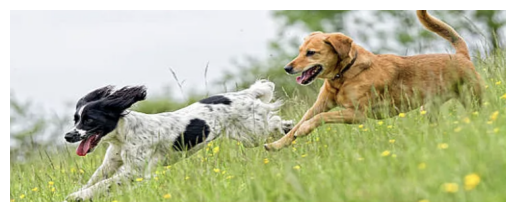

I0000 00:00:1720025065.483592     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


dog runs through the grass


In [21]:
from PIL import Image
def create_caption(img_path, model, xmodel, tokenizer, max_length, img_size):
 
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.axis('off')  
    plt.show()
    img = img.resize((img_size, img_size))
    img = np.array(img)
    
    img = np.expand_dims(img, axis=0)
    img = img/127.5
    img = img - 1.0
    
#     img = xmodel.preprocess_input(img)
    
   
    feature = xmodel.predict(img, verbose=0)
    
  
    in_text = 'startseq'
    
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        

        word = idx_to_word(y_pred, tokenizer)
        

        in_text += ' ' + word
        

        if word == 'endseq':
            break
    
   
    caption = in_text.split()[1:-1]
    caption = ' '.join(caption)
    
    return caption



caty_path = "/kaggle/input/capybar/cap.png"
cap = create_caption(caty_path, model, xmodel, tokenizer, max_length, 299)
print(cap)
# img_size = 299
# img = Image.open(caty_path)
# img = img.resize((img_size, img_size))
# img = np.array(img)
# img = np.expand_dims(img, axis=0)
# print(img.shape)

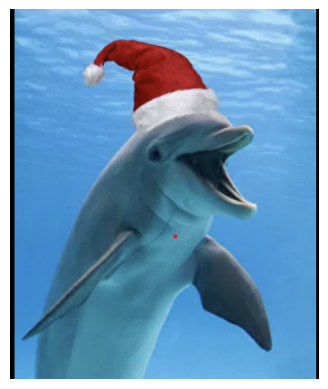

man in blue shirt is standing in front of an airplane


In [22]:
path = "/kaggle/input/ghskal/one_more.png"
cap = create_caption(path, model, xmodel, tokenizer, max_length, 299)
print(cap)